In [1]:
# add ../prysm to the system path so it is found by Python -- this is not needed if you install the module
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
from prysm import Seidel, FringeZernike, PSF, MultispectralPSF, RGBPSF, MTF
from prysm.conf import config
from prysm.geometry import rotated_ellipse
from prysm.objects import Image

from matplotlib import pyplot as plt
%matplotlib inline
config.set_precision(32)
config.set_backend('cu')

In [2]:
# make a pupil for equal RMS value of each of the fringe zernike polynomials
efl = 50
fno = 3
abers = np.ones(48) * 40
pupil_args = dict(epd=efl/fno, opd_unit='nm', rms_norm=True)
pupil = FringeZernike(abers, **pupil_args)

# PSFs are generated from pupils, given an EFL.  They cannot be generated for afocal systems.
psf = PSF.from_pupil(pupil, efl=efl)

# PSFs carry methods allowing them to be plotted in 2D,
#psf.plot2d(axlim=75)

# plots can be log or linear scale.  Currently, the log implementation does not display properly
#psf.plot2d(axlim=75, log=True)

# or in 1D
#psf.plot_slice_xy(axlim=75)

# encircled energy can also be plotted without an intermediate function
#psf.plot_encircled_energy(azimuth=85, axlim=75)

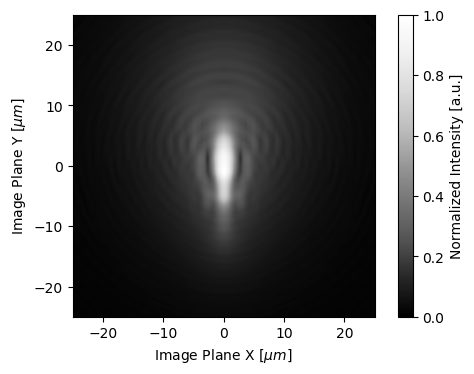

In [3]:
# multispecal PSFs are possible, combining PSFs generated at different wavelengths
# here, we show spherochromatism
base_aberrations = dict(W040=0.5, W020=-0.25, W222=0.33, W131=0.33)
pup1 = Seidel(W111=-0.3, **base_aberrations, wavelength=0.40, opd_unit='um', epd=efl/fno)
pup2 = Seidel(W111=0, **base_aberrations, wavelength=0.55, opd_unit='um', epd=efl/fno)
pup3 = Seidel(W111=0.4, **base_aberrations, wavelength=0.70, opd_unit='um', epd=efl/fno)

# generate a PSF for each color
psf1 = PSF.from_pupil(pup1, efl)
psf2 = PSF.from_pupil(pup2, efl)
psf3= PSF.from_pupil(pup3, efl)

# combine into a panchromatic PSF, with the spectrum weighted towards green
multpsf = MultispectralPSF([psf1, psf2, psf3], [0.75, 2, 1])
multpsf.plot2d()

# combine into an RGBPSF, where there are three distinct color channels
# (this could also be done with multispectral PSFs for each channel, for e.g. bayer-esque simulation)
rgb = RGBPSF(r_psf = psf3, g_psf = psf2, b_psf = psf1)
#rgb.plot2d()
#rgb.plot2d_rgbgrid()

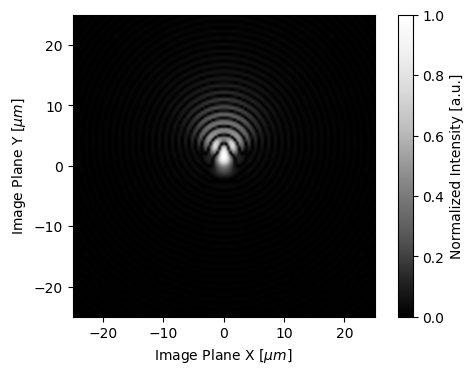

In [4]:
p = Seidel(W131=1)
pp = PSF.from_pupil(p, efl=2)
pp.plot2d()
m = MTF.from_psf(pp)
#m.plot2d(max_freq=1000)
#plt.savefig('astig_mtf.png')

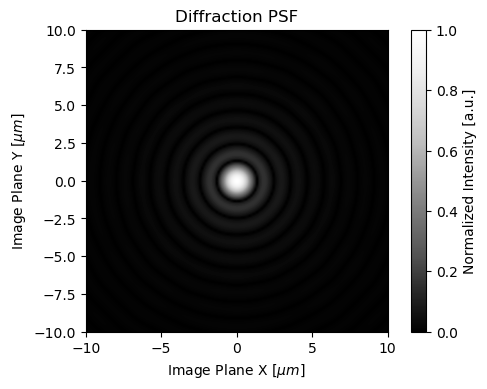

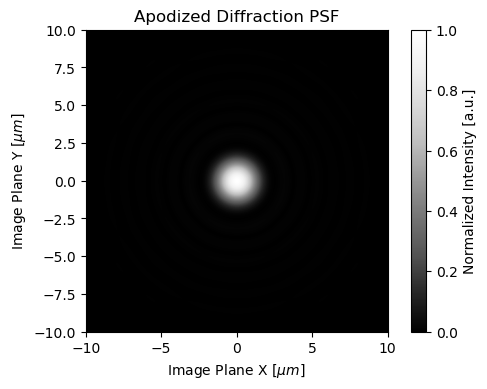

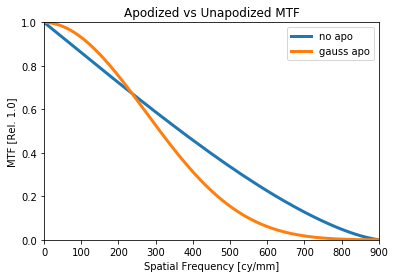

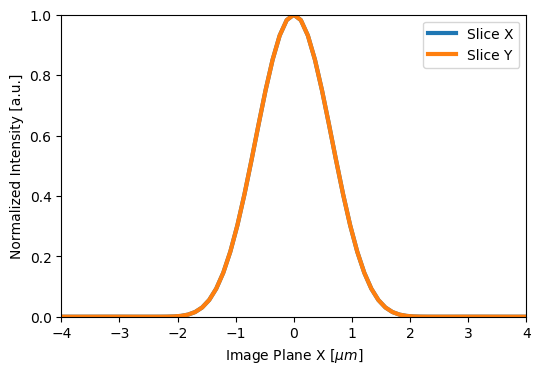

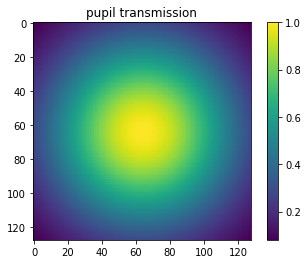

In [5]:
from prysm.geometry import hexagon as mskshape
from prysm.geometry import gaussian, rotated_ellipse
from prysm.util import correct_gamma
mask = mskshape()

#plt.imshow(mask)
pupil = Seidel(epd=25)
#pupil.mask(mask)
#pupil.mask(gaussian())
psf1 = PSF.from_pupil(pupil, 50, 4)
psf1.plot2d(axlim=10)
plt.gca().set_title('Diffraction PSF')
#plt.savefig('diff_psf.png', bbox_inches='tight')

mtf1 = MTF.from_psf(psf1) # cutoff ~= 900lp
u1, t1 = mtf1.tan

psf2 = PSF.from_pupil(pupil.mask(gaussian()), 50, 4)
psf2.plot2d(axlim=10)
plt.gca().set_title('Apodized Diffraction PSF')
#plt.savefig('diff_psf_apo.png', bbox_inches='tight')

mtf2 = MTF.from_psf(psf2)
u2, t2 = mtf2.tan

fig, ax = plt.subplots()
ax.plot(u1,t1, lw=3, label='no apo')
ax.plot(u2,t2, lw=3, label='gauss apo')
ax.set(xlim=(0,900), xlabel='Spatial Frequency [cy/mm]',
       ylim=(0,1), ylabel='MTF [Rel. 1.0]',
       title='Apodized vs Unapodized MTF')
plt.legend()
#plt.savefig('diff_mtf_comp.png', bbox_inches='tight')

psf2.plot_slice_xy(axlim=4)
plt.savefig('psf_profile.png', bbox_inches='tight')

fig, ax = plt.subplots()
ii = ax.imshow(correct_gamma(gaussian()))
fig.colorbar(ii)
ax.set(title='pupil transmission')
plt.savefig('pup_transmission.png', bbox_inches='tight')

(<matplotlib.figure.Figure at 0x18f47e87438>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18f47d634a8>)

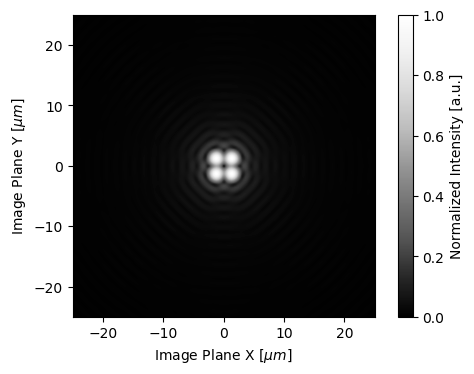

In [6]:
from prysm.geometry import rotated_ellipse
from prysm.objects import Slit, Pinhole, SiemensStar
from prysm.detector import Detector
from prysm import OLPF, PixelAperture

efl = 200
fno = 2.8
# make a 4.8um pixel camera
d = Detector(4.8)
pup9 = FringeZernike(np.random.rand(48)*0.001, epd=efl/fno, samples=128)
psf9 = PSF.from_pupil(pup9, efl, 2)
psf10 = psf9.conv(OLPF(4))
psf10.plot2d(axlim=25)

(<matplotlib.figure.Figure at 0x18f47cf40b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18f4940cb70>)

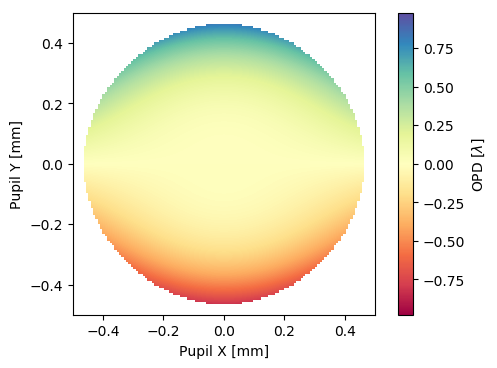

In [7]:
p.plot2d()